In [1]:
import os,time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageOps
from glob import glob
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [2]:
GPUs= tf.config.experimental.list_physical_devices("GPU")
if GPUs:
    try:
        for gpu in GPUs:
            tf.config.experimental.set_memory_growth(gpu,True)
        logical_gpus=tf.config.experimental.list_logical_devices("GPU")
        print(len(GPUs),"physical GPUs,",len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        raise e

1 physical GPUs, 1 Logical GPUs


In [4]:
# import ipynb_importer
from myutils import make_anime_dataset,show_pred,show_history

In [5]:
def single_pred(img,D):
    img=np.array(img)/127.5 - 1
    img=tf.expand_dims(img,0)
    pred=D(img,training=False)
    print(pred.numpy())
    show_pred(img,predict=True,D=D,categorical=False)

In [6]:
ckpt_dir="./checkpoints/Yuzu"
re_dir="./results/Yuzu"

post_dataset_path="D:\jupyter\Dataset\After"

hash_output={"こぶいち":1,
             "むりりん":2,
             "こもわた遥華":3,
             "Other":0}

def get_classes():
    classes=[]
    for i in range(len(hash_output.keys())):
        classes.append(None)
        
    for key,item in hash_output.items():
        classes[item]=key
    
    return classes

def get_id(inputs,hash_table):
    if (inputs in hash_table.keys()):
        re=hash_table[inputs]
    else:
        re=hash_table["Other"]
        
    return re

def get_datas(path):
    folders=glob(os.path.join(path,'*'))
    folders.remove(os.path.join(path,'OtherResolution'))
    filenames=[]
    labels=[]
    for folder in folders:
        images=glob(os.path.join(folder,'*'))
        filenames=filenames+images

        hash_key=os.path.split(folder)[1]
        hash_value=get_id(hash_key,hash_table=hash_output)
        label=[hash_value]*len(images)
        labels=labels+label
        print(hash_key,"\tvalue=",hash_value,",nums=",len(label))

    #[1,None]->[None,1]
    labels=np.reshape(labels,[-1,1])
    return filenames,labels

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
if not os.path.exists(re_dir):
    os.makedirs(re_dir)

In [7]:
#InceptionNet V3
class ConvBNRelu(tf.keras.Model):
    def __init__(self,activation=tf.nn.relu,**kargs):
        if ('name' in kargs):
            super(ConvBNRelu,self).__init__(name=kargs['name'])
        else:
            super(ConvBNRelu,self).__init__()
        self.conv=layers.Conv2D(use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(5e-4),**kargs)
        self.bn=layers.BatchNormalization()
        self.act=activation
    
    def call(self,x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.act(x)
        return x
        
class DownScale(tf.keras.Model):
    def __init__(self,strides,**kargs):
        super(DownScale,self).__init__(**kargs)
        
        self.conv1=ConvBNRelu(filters=32,kernel_size=(3,3),strides=2,padding='same')
        self.conv2=ConvBNRelu(filters=32,kernel_size=(3,3),strides=1,padding='same')
        self.conv3=ConvBNRelu(filters=64,kernel_size=(3,3),strides=1,padding='same')
        self.pool4=layers.MaxPool2D(pool_size=strides)
        self.conv4=ConvBNRelu(filters=96,kernel_size=(5,5),strides=strides,padding='same')
        self.concat1=layers.Concatenate(axis=3)
        self.conv51=ConvBNRelu(filters=64,kernel_size=(1,1),strides=1)
        self.conv52=ConvBNRelu(filters=96,kernel_size=(3,3),strides=1,padding='same')
        self.conv61=ConvBNRelu(filters=64,kernel_size=(1,1),strides=1)
        self.conv62=ConvBNRelu(filters=64,kernel_size=(1,7),strides=1,padding='same')
        self.conv63=ConvBNRelu(filters=64,kernel_size=(7,1),strides=1,padding='same')
        self.conv64=ConvBNRelu(filters=96,kernel_size=(3,3),strides=1,padding='same')
        self.concat2=layers.Concatenate(axis=3)
        self.pool7=layers.MaxPool2D(pool_size=strides)
        self.conv7=ConvBNRelu(filters=192,kernel_size=(5,5),strides=strides,padding='same')
        self.concat3=layers.Concatenate(axis=3)
        
    def call(self,inputs):
        x=self.conv3(self.conv2(self.conv1(inputs)))
        x1=self.pool4(x)
        x2=self.conv4(x)
        x=self.concat1([x1,x2])
        x1=self.conv52(self.conv51(x))
        x2=self.conv64(self.conv63(self.conv62(self.conv61(x))))
        x=self.concat2([x1,x2])
        x1=self.pool7(x)
        x2=self.conv7(x)
        x=self.concat3([x1,x2])
        return x
        
class InceptionModule_1(tf.keras.Model):
    def __init__(self,inner,outer,**kargs):
        super(InceptionModule_1,self).__init__(**kargs)
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[1],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_22')
        self.c3_1=ConvBNRelu(filters=inner[2],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[2],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_32')
        self.c3_3=ConvBNRelu(filters=outer[2],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_33')
        self.p4_1=layers.AvgPool2D(3,strides=1,padding='same',name='pool')
        self.c4_2=ConvBNRelu(filters=outer[3],kernel_size=(1,1),strides=1,name='conv1x1_4')
        self.concat=layers.Concatenate(axis=3,name='concat')
        
    def call(self,inputs):
        x1 = self.c1(inputs)
        x2=self.c2_2(self.c2_1(inputs))
        x3=self.c3_3(self.c3_2(self.c3_1(inputs)))
        x4=self.c4_2(self.p4_1(inputs))
        
        x=self.concat([x1,x2,x3,x4])
        return x

class InceptionModuleReduced_1(tf.keras.Model):
    def __init__(self,inner,outer,strides=2,**kargs):
        super(InceptionModuleReduced_1,self).__init__(**kargs)
        
        if type(outer) is int:
            outer=[outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        
        self.c2_1=ConvBNRelu(filters=inner[0],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[0],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_22')
        self.c3_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[1],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_32')
        self.c3_3=ConvBNRelu(filters=outer[1],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_33')
        self.p4_1=layers.AvgPool2D(3,strides=strides,padding='same',name='pool')
        self.concat=layers.Concatenate(axis=3,name='concat')
        
    def call(self,inputs):
        x2=self.c2_2(self.c2_1(inputs))
        x3=self.c3_3(self.c3_2(self.c3_1(inputs)))
        x4=self.p4_1(inputs)
        
        x=self.concat([x2,x3,x4])
        return x
    
class InceptionModule_2(tf.keras.Model):
    def __init__(self,inner,outer,**kargs):
        super(InceptionModule_2,self).__init__(**kargs)
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=inner[1],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_22')
        self.c2_3=ConvBNRelu(filters=outer[1],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_23')
        self.c3_1=ConvBNRelu(filters=inner[2],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[2],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_32')
        self.c3_3=ConvBNRelu(filters=inner[2],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_33')
        self.c3_4=ConvBNRelu(filters=inner[2],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_34')
        self.c3_5=ConvBNRelu(filters=outer[2],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_35')
        self.p4_1=layers.AvgPool2D(3,strides=1,padding='same',name='pool')
        self.c4_2=ConvBNRelu(filters=outer[3],kernel_size=(1,1),strides=1,name='conv1x1_4')
        self.concat=layers.Concatenate(axis=3)
        
    def call(self,inputs):
        x1 = self.c1(inputs)
        x2=self.c2_3(self.c2_2(self.c2_1(inputs)))
        x3=self.c3_5(self.c3_4(self.c3_3(self.c3_2(self.c3_1(inputs)))))
        x4=self.c4_2(self.p4_1(inputs))
        
        x=self.concat([x1,x2,x3,x4])
        return x
    
class InceptionModuleReduced_2(tf.keras.Model):
    def __init__(self,inner,outer,strides=2,**kargs):
        super(InceptionModuleReduced_2,self).__init__(**kargs)
        
        if type(outer) is int:
            outer=[outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        
        self.c2_1=ConvBNRelu(filters=inner[0],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[0],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_22')
        self.c3_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[1],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_32')
        self.c3_3=ConvBNRelu(filters=inner[1],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_33')
        self.c3_4=ConvBNRelu(filters=outer[1],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_34')
        self.p4_1=layers.AvgPool2D(3,strides=strides,padding='same',name='pool')
        self.concat=layers.Concatenate(axis=3)
        
        
    def call(self,inputs):
        x2=self.c2_2(self.c2_1(inputs))
        x3=self.c3_4(self.c3_3(self.c3_2(self.c3_1(inputs))))
        x4=self.p4_1(inputs)
        
        x=self.concat([x2,x3,x4])
        return x
    
class InceptionModule_3(tf.keras.Model):
    def __init__(self,inner,outer):
        super(InceptionModule_3,self).__init__()
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[1],kernel_size=(1,3),strides=1,padding='same',name='conv1x3_22')
        self.c2_3=ConvBNRelu(filters=outer[1],kernel_size=(3,1),strides=1,padding='same',name='conv3x1_23')
        self.c3_1=ConvBNRelu(filters=inner[2],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[2],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_32')
        self.c3_3=ConvBNRelu(filters=outer[2],kernel_size=(1,3),strides=1,padding='same',name='conv1x3_33')
        self.c3_4=ConvBNRelu(filters=outer[2],kernel_size=(3,1),strides=1,padding='same',name='conv3x1_34')
        self.p4_1=layers.AvgPool2D(3,strides=1,padding='same',name='pool')
        self.c4_2=ConvBNRelu(filters=outer[3],kernel_size=(1,1),strides=1,name='conv1x1_4')
        self.concat=layers.Concatenate(axis=3)
        
        
    def call(self,inputs):
        x1 = self.c1(inputs)
        x2=self.c2_1(inputs)
        x21=self.c2_2(x2)
        x22=self.c2_3(x2)
        x3=self.c3_2(self.c3_1(inputs))
        x31=self.c3_3(x3)
        x32=self.c3_4(x3)
        x4=self.c4_2(self.p4_1(inputs))
        
        x=self.concat([x1,x21,x22,x31,x32,x4])
        return x

In [8]:
#InceptionNet V4
class InceptionResModule_1(tf.keras.Model):
    def __init__(self,inner,outer):
        super().__init__()
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[1],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_22')
        self.c3_1=ConvBNRelu(filters=inner[2],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[2],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_32')
        self.c3_3=ConvBNRelu(filters=outer[2],kernel_size=(3,3),strides=1,padding='same',name='conv3x3_33')
        self.concat=layers.Concatenate(axis=3)
        self.conv=layers.Conv2D(filters=outer[3],kernel_size=(1,1),strides=1,name='conv')
        
    def call(self,inputs):
        x1=self.c1(inputs)
        x2=self.c2_2(self.c2_1(inputs))
        x3=self.c3_3(self.c3_2(self.c3_1(inputs)))
        x=self.concat([x1,x2,x3])
        x=self.conv(x)
        x+=inputs
        return x
    
class InceptionResModule_2(tf.keras.Model):
    def __init__(self,inner,outer):
        super().__init__()
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=inner[1],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_22')
        self.c2_3=ConvBNRelu(filters=outer[1],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_23')
        self.concat=layers.Concatenate(axis=3)
        self.conv=layers.Conv2D(filters=outer[3],kernel_size=(1,1),strides=1,name='conv')
        
        
    def call(self,inputs):
        x1=self.c1(inputs)
        x2=self.c2_3(self.c2_2(self.c2_1(inputs)))
        
        x=self.concat([x1,x2])
        x=self.conv(x)
        x+=inputs
        return x
    
class InceptionResModuleReduced_2(tf.keras.Model):
    def __init__(self,inner,outer,strides=2,**kargs):
        super().__init__(**kargs)
        
        if type(outer) is int:
            outer=[outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner,inner]
        
        self.c1_1=ConvBNRelu(filters=inner[0],kernel_size=(1,1),strides=1,name='conv1x1_11')
        self.c1_2=ConvBNRelu(filters=outer[0],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_12')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[1],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_22')
        self.c3_1=ConvBNRelu(filters=inner[2],kernel_size=(1,1),strides=1,name='conv1x1_31')
        self.c3_2=ConvBNRelu(filters=inner[2],kernel_size=(1,7),strides=1,padding='same',name='conv1x7_32')
        self.c3_3=ConvBNRelu(filters=inner[2],kernel_size=(7,1),strides=1,padding='same',name='conv7x1_33')
        self.c3_4=ConvBNRelu(filters=outer[2],kernel_size=(3,3),strides=strides,padding='same',name='conv3x3_34')
        self.p4_1=layers.AvgPool2D(3,strides=strides,padding='same',name='pool')
        self.concat=layers.Concatenate(axis=3)
        
        
    def call(self,inputs):
        x1=self.c1_2(self.c1_1(inputs))
        x2=self.c2_2(self.c2_1(inputs))
        x3=self.c3_4(self.c3_3(self.c3_2(self.c3_1(inputs))))
        x4=self.p4_1(inputs)
        
        x=self.concat([x1,x2,x3,x4])
        return x
    
class InceptionResModule_3(tf.keras.Model):
    def __init__(self,inner,outer):
        super().__init__()
        
        if type(outer) is int:
            outer=[outer,outer,outer,outer]
        if inner is None:
            inner=outer
        if type(inner) is int:
            inner=[inner,inner]
        if len(inner) == 2:
            inner=[0,inner[0],inner[1],0]
        
        self.c1 = ConvBNRelu(filters=outer[0],kernel_size=(1,1),strides=1,name='conv1x1_1')
        self.c2_1=ConvBNRelu(filters=inner[1],kernel_size=(1,1),strides=1,name='conv1x1_21')
        self.c2_2=ConvBNRelu(filters=outer[1],kernel_size=(1,3),strides=1,padding='same',name='conv1x3_22')
        self.c2_3=ConvBNRelu(filters=outer[1],kernel_size=(3,1),strides=1,padding='same',name='conv3x1_23')
        self.concat=layers.Concatenate(axis=3)
        self.conv=layers.Conv2D(filters=outer[3],kernel_size=(1,1),strides=1,name='conv')
        
        
    def call(self,inputs):
        x1 = self.c1(inputs)
        x2=self.c2_3(self.c2_2(self.c2_1(inputs)))
        
        x=self.concat([x1,x2])
        x=self.conv(x)
        x+=inputs
        return x

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        #Block0
        self.conv0=DownScale(strides=(3,4))
        #Block1
        self.conv1=tf.keras.models.Sequential([
            InceptionResModule_1(inner=32,outer=[32,32,64,384]),
            InceptionResModule_1(inner=32,outer=[32,32,64,384]),
            InceptionResModule_1(inner=32,outer=[32,32,64,384]),
            InceptionResModule_1(inner=32,outer=[32,32,64,384]),
            InceptionResModule_1(inner=32,outer=[32,32,64,384]),
        ],name='block1')
        #Block2
        self.conv2=InceptionModuleReduced_1(inner=256,outer=[384,384],name='block2')
        #Block3
        self.conv3=tf.keras.models.Sequential([
            InceptionResModule_2(inner=128,outer=[192,192,0,1152]),
            InceptionResModule_2(inner=128,outer=[192,192,0,1152]),
            InceptionResModule_2(inner=128,outer=[192,192,0,1152]),
            InceptionResModule_2(inner=128,outer=[192,192,0,1152]),
            InceptionResModule_2(inner=128,outer=[192,192,0,1152]),
        ],name='block3')
        #Block4
        self.conv4=InceptionResModuleReduced_2(inner=256,outer=[384,256,256],name='block4')
        #Block5
        self.conv5=tf.keras.models.Sequential([
            InceptionResModule_3(inner=192,outer=[192,256,0,2048]),
            InceptionResModule_3(inner=192,outer=[192,256,0,2048]),
            InceptionResModule_3(inner=192,outer=[192,256,0,2048]),
            InceptionResModule_3(inner=192,outer=[192,256,0,2048]),
            InceptionResModule_3(inner=192,outer=[192,256,0,2048]),
        ],name='block5')
        #Conv to Dense
        self.flatten=layers.GlobalAveragePooling2D(name='flatten')
        self.dropout=layers.Dropout(0.2)
        self.out=layers.Dense(4,activation='softmax',name='out')
        
    def call(self, inputs, training=None):
        #x=tf.cast(inputs,tf.float32)
        x=self.conv0(inputs)
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.flatten(x)
        x=self.dropout(x)
        x=self.out(x)
        return x
    
    def plot_model(self,shape):
        x=layers.Input(shape=shape)
        y=self.call(x)
        model=tf.keras.Model(inputs=x,outputs=y)
        display(tf.keras.utils.plot_model(model,show_shapes=True,dpi=64))

In [10]:
batch_size=4
filenames,labels=get_datas(post_dataset_path)
dataset,size=make_anime_dataset(filenames,labels=labels,batch_size=batch_size,return_size=True)
data_iter=iter(dataset)
h,w,_=size
print(size)

Other 	value= 0 ,nums= 167
こぶいち 	value= 1 ,nums= 176
こもわた遥華 	value= 3 ,nums= 355
むりりん 	value= 2 ,nums= 193
(360, 640, 3)


In [11]:
Image_Generator=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                                width_shift_range=0.20,
                                                                height_shift_range=0.15,
                                                                horizontal_flip=True,
                                                                zoom_range=0.25,
                                                                preprocessing_function=lambda x:x/127.5-1,
                                                                fill_mode='constant',
                                                                cval=255,
                                                                validation_split=0.2)

gen_train=Image_Generator.flow_from_directory(post_dataset_path,
                                              classes=get_classes(),
                                              class_mode='categorical',
                                              shuffle=True,
                                              target_size=(h,w),
                                              batch_size=batch_size,
                                              subset='training')
gen_valid=Image_Generator.flow_from_directory(post_dataset_path,
                                              classes=get_classes(),
                                              class_mode='categorical',
                                              target_size=(h,w),
                                              shuffle=True,
                                              batch_size=batch_size,
                                              subset='validation')

Found 714 images belonging to 4 classes.
Found 177 images belonging to 4 classes.


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
down_scale (DownScale)       multiple                  1295584   
_________________________________________________________________
block1 (Sequential)          multiple                  620800    
_________________________________________________________________
block2 (InceptionModuleReduc multiple                  2562048   
_________________________________________________________________
block3 (Sequential)          multiple                  5507200   
_________________________________________________________________
block4 (InceptionResModuleRe multiple                  3875328   
_________________________________________________________________
block5 (Sequential)          multiple                  10268160  
_________________________________________________________________
flatten (GlobalAveragePoolin multiple                

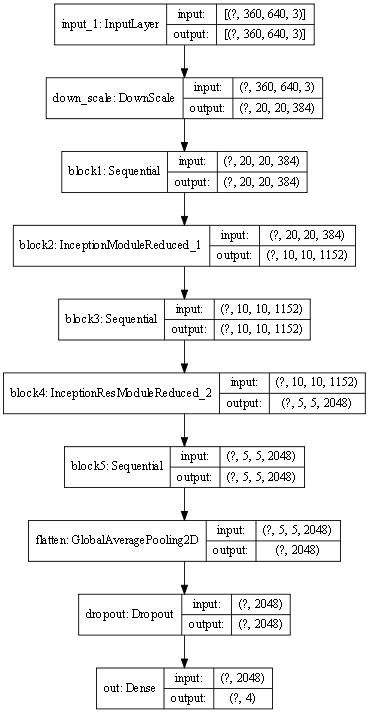

In [12]:
D=Discriminator()
D.build(input_shape=((None,)+size))
D.summary()
D.plot_model(shape=size)

In [13]:
OEStop=tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=1e-2,patience=3,verbose=1)
EStop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-2,patience=5,verbose=1)
LRReduce=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',min_delta=1e-2,min_lr=1e-7,
                                              patience=2,cooldown=2,verbose=1)
CategoricalCE=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
d_optimizer= tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)

Train for 300 steps
Epoch 1/10
300/300 [==============================] - 51s 169ms/step - loss: 11.0280 - accuracy: 0.5233
Epoch 2/10
300/300 [==============================] - 36s 121ms/step - loss: 9.1908 - accuracy: 0.6933
Epoch 3/10
300/300 [==============================] - 37s 122ms/step - loss: 8.4197 - accuracy: 0.7625
Epoch 4/10
300/300 [==============================] - 37s 122ms/step - loss: 7.7118 - accuracy: 0.8217
Epoch 5/10
300/300 [==============================] - 36s 122ms/step - loss: 7.0916 - accuracy: 0.8408
Epoch 6/10
300/300 [==============================] - 37s 122ms/step - loss: 6.4319 - accuracy: 0.8858
Epoch 7/10
300/300 [==============================] - 37s 122ms/step - loss: 5.9168 - accuracy: 0.8892
Epoch 8/10
300/300 [==============================] - 37s 122ms/step - loss: 5.4087 - accuracy: 0.9025
Epoch 9/10
300/300 [==============================] - 36s 122ms/step - loss: 4.9160 - accuracy: 0.9050
Epoch 10/10
300/300 [==============================]

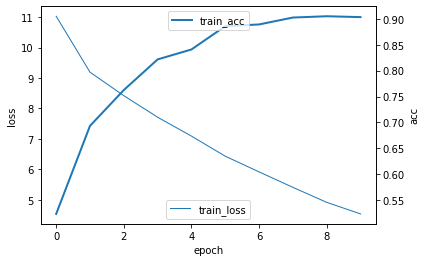

In [14]:
#预训练
D.compile(optimizer=d_optimizer,
          loss=tf.keras.losses.sparse_categorical_crossentropy,
          metrics=['accuracy'])
history=D.fit(dataset,
              epochs=10,
              steps_per_epoch=300,
              validation_data=None,
              callbacks=[OEStop])
show_history(history,validation=False)

Train for 179 steps, validate for 45 steps
Epoch 1/20
179/179 [==============================] - 69s 386ms/step - loss: 5.4301 - accuracy: 0.6317 - val_loss: 7.8324 - val_accuracy: 0.3107
Epoch 2/20
179/179 [==============================] - 58s 327ms/step - loss: 4.7538 - accuracy: 0.7115 - val_loss: 8.0690 - val_accuracy: 0.2825
Epoch 3/20
179/179 [==============================] - 57s 320ms/step - loss: 4.3660 - accuracy: 0.7493 - val_loss: 5.0538 - val_accuracy: 0.3277
Epoch 4/20
179/179 [==============================] - 57s 320ms/step - loss: 4.0769 - accuracy: 0.7899 - val_loss: 5.3728 - val_accuracy: 0.3164
Epoch 5/20
179/179 [==============================] - 57s 319ms/step - loss: 3.7685 - accuracy: 0.8403 - val_loss: 4.4288 - val_accuracy: 0.4972
Epoch 6/20
179/179 [==============================] - 58s 321ms/step - loss: 3.6043 - accuracy: 0.8501 - val_loss: 4.6927 - val_accuracy: 0.4011
Epoch 7/20
179/179 [==============================] - 57s 321ms/step - loss: 3.4014 - a

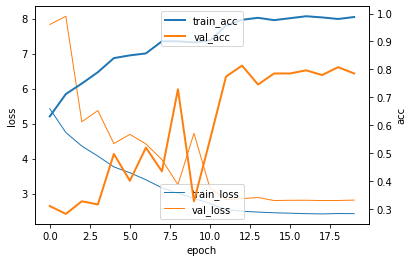

In [15]:
#数据增强
D.compile(optimizer=d_optimizer,
          loss=CategoricalCE,
          metrics=['accuracy'])
history=D.fit(gen_train,
              epochs=20,
              steps_per_epoch=None,
              shuffle=False,
              validation_data=gen_valid,
              validation_steps=None,
              callbacks=[EStop,LRReduce])
show_history(history,validation=True)

In [ ]:
bool_load=True
if bool_load:
    D.load_weights(ckpt_dir+'/discriminator.ckpt')

In [ ]:
D.save_weights(ckpt_dir+'/discriminator.ckpt')

In [ ]:
D.evaluate(gen_valid)

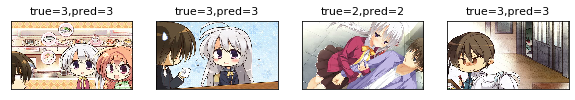

In [16]:
#用训练集测试
x,y=next(data_iter)
show_pred(x,y,predict=True,D=D,categorical=False)

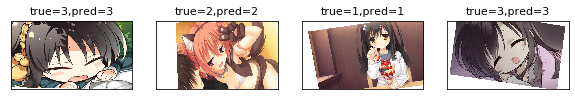

In [17]:
#用数据增强后的训练集测试
x,y=next(gen_train)
show_pred(x,y,predict=True,D=D,categorical=True)

In [ ]:
#用其余图片测试
path=os.path.join(r'D:\jupyter\Dataset\魔女的夜宴','*','Sanoba_1250*')
path=glob(path)[0]
img=Image.open(path)
img=ImageOps.pad(img,(w,h),method=Image.ANTIALIAS,color='white')
img=img.convert('RGB')

single_pred(img,D)

In [ ]:
#取出test文件夹中的测试图片，并逐一查看预测值
paths=glob(r'D:\jupyter\Dataset\test\*')
test_iter=iter(paths)
img=Image.open(next(test_iter))
img=ImageOps.pad(img,(w,h),method=Image.ANTIALIAS,color='white')
img=img.convert('RGB')

single_pred(img,D)

35

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



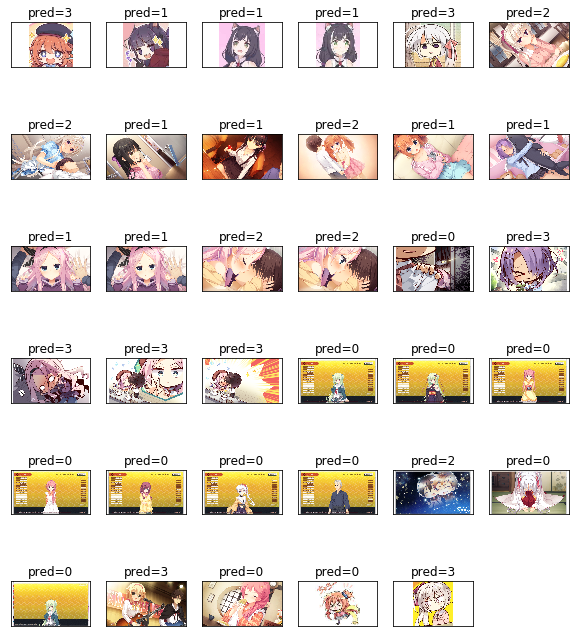

In [18]:
#总览test文件夹中的预测情况
paths=glob(r'D:\jupyter\Dataset\test\*')
imgs=[]
for path in paths:
    img=Image.open(path).convert('RGB')
    img=ImageOps.pad(img,(w,h),method=Image.ANTIALIAS,color='white')
    img=np.array(img)/127.5-1
    imgs.append(img)
print(len(imgs))
show_pred(np.array(imgs),predict=True,D=D,categorical=True,max_num_shown=36)